In [1]:
import torch
from torch import nn
from torchvision.models import vit_b_16
from transformers import ViTImageProcessor, ViTModel

from model import ViTEmbedding

2024-04-02 11:27:13.147014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2024-04-02 11:27:13.147053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device = torch.device('cuda')

In [3]:
patch_embedding = nn.Sequential(
                      ViTEmbedding(),
                      nn.Linear(768, 64),
                  )

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
patch_embedding[0]

ViTEmbedding(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072

In [5]:
x = torch.rand((16,3,320,480), device=device)

In [6]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model_clf = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
input = processor(images=x, return_tensors="pt", do_rescale=False).to(device)

In [8]:
outputs = model_clf(**input)

In [9]:
outputs['last_hidden_state'].shape

torch.Size([16, 197, 768])

In [10]:
input['pixel_values'].shape

torch.Size([16, 3, 224, 224])

In [11]:
from config import Config, load_config
from data import build_datasets

config = load_config()
config.multimodal_pretraining = True
config.not_normalize_image = True
train_dataset, test_dataset, systematic_dataset = build_datasets(config)

In [12]:
image, scene = train_dataset.retrieve_raw(0)

In [13]:
train_dataset

In [14]:
from transformers import ViTMAEForPreTraining, ViTMAEConfig, AutoImageProcessor

In [15]:
config = ViTMAEConfig()
mae = ViTMAEForPreTraining(config)

In [16]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")

In [17]:
inputs = image_processor(images=[image], return_tensors="pt")
outputs = mae(**inputs)

In [18]:
image, *_ = train_dataset[0] 

In [19]:
image = image.unsqueeze(0)

In [30]:
image

torch.Size([1, 3, 224, 224])

torch.Size([3, 14, 14, 16, 16])
torch.Size([196, 3, 16, 16])


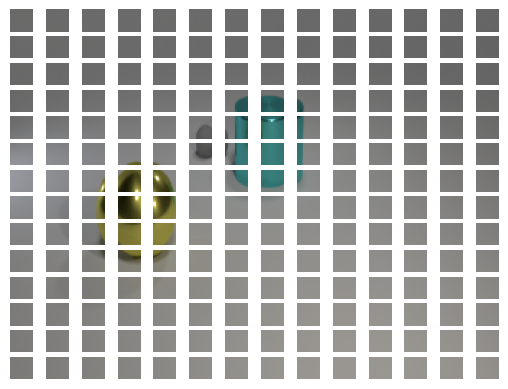

In [116]:
x = image[0]

patch_size = 16

y = x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
print(y.shape)
y = y.contiguous().view(y.size(0), -1, patch_size, patch_size)
y = y.permute(1, 0, 2, 3).contiguous()
print(y.shape)

h = image.size(2) // patch_size
w = image.size(3) // patch_size

fig, axarr = plt.subplots(h, w)
axarr = axarr.reshape(-1)
for idx, y_ in enumerate(y):
    axarr[idx].imshow(y_.permute(1, 2, 0).contiguous().numpy())
    axarr[idx].axis('off')

In [51]:
y.flatten(1).shape, y.shape

(torch.Size([196, 768]), torch.Size([196, 3, 16, 16]))

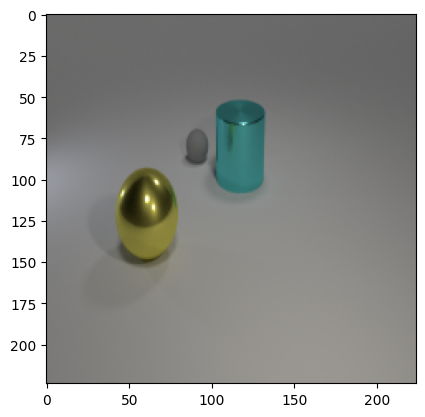

In [52]:
y_flat = y.flatten(1)
y_non_flat = y_flat.reshape(-1, 3, 16,16)
x_tau =  (y_non_flat.permute(1,0,2,3).reshape(3,14,14,16,16).permute(0,1,3,2,4).reshape(3,224,224))
plt.imshow(x_tau.permute(1, 2, 0))

In [108]:
n, tp, *_ = y.unsqueeze(0).shape
t = 35 + tp

probability_matrix = torch.full((n, t), 0.75)
masked_indices = torch.bernoulli(probability_matrix).bool()

masked_indices.shape

torch.Size([1, 231])

In [114]:
probability_matrix[:,torch.arange(0,t) > tp] = 0

In [115]:
probability_matrix

tensor([[0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
         0.7500, 0.7500, 0.7

In [77]:
from torch.nn import functional as F

In [78]:
pred = torch.rand(8, 196, 3, 16, 16)
tgt = torch.rand(8, 196, 3, 16, 16)

In [79]:
F.mse_loss(pred, tgt, reduction='none').mean((-1,-2,-3)).shape

torch.Size([8, 196])

In [80]:
masked_indices.shape

torch.Size([8, 196])

In [81]:
patches = torch.rand(8, 196, 3*16*16)
pred_patch_embedding = torch.rand(1, 1, 3*16*16)

In [91]:
replaced = (masked_indices.unsqueeze(-1) * pred_patch_embedding) + (~masked_indices.unsqueeze(-1) * patches)

In [103]:
(replaced == pred_patch_embedding).all(-1)

tensor(True)

In [100]:
masked_indices.sum()

tensor(1183)